**We want to figure out the best learning rate for a batch size of 128**

In [1]:
# Ran with 800GB (750GB should also be fine)

import sys
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import os
import copy
import gc

#Import sklearn before tensorflow (static Thread-local storage)
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Activation

t0 = time.time()
path = '/pf/b/b309170'
path_figures = path + '/workspace_icon-ml/cloud_cover_parameterization/grid_column_based_QUBICC_R02B05/figures'
path_model = path + '/workspace_icon-ml/cloud_cover_parameterization/grid_column_based_QUBICC_R02B05/saved_models'
path_data = path + '/my_work/icon-ml_data/cloud_cover_parameterization/grid_column_based_QUBICC_R02B05/based_on_var_interpolated_data'

# Add path with my_classes to sys.path
sys.path.insert(0, path + '/workspace_icon-ml/cloud_cover_parameterization/')

# Reloading custom file to incorporate changes dynamically
import importlib
import my_classes
importlib.reload(my_classes)

from my_classes import read_mean_and_std
from my_classes import TimeOut

# Minutes per fold
# timeout = 710 ####
timeout = 100 ##

# For logging purposes
days = 'all_days'

# Maximum amount of epochs for each model
epochs = 50

# Set seed for reproducibility
seed = 10
tf.random.set_seed(seed)

# For store_mean_model_biases
VERT_LAYERS = 31

gpus = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_visible_devices(gpus[3], 'GPU')

In [2]:
# Prevents crashes of the code
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(physical_devices[0], 'GPU')

In [3]:
# # Allow the growth of memory Tensorflow allocates (limits memory usage overall)
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
scaler = StandardScaler()

### Load the data

In [5]:
# input_narval = np.load(path_data + '/cloud_cover_input_narval.npy')
# input_qubicc = np.transpose(np.load(path_data + '/cloud_cover_input_qubicc.npy'))
# output_narval = np.load(path_data + '/cloud_cover_output_narval.npy')
# output_qubicc = np.transpose(np.load(path_data + '/cloud_cover_output_qubicc.npy'))

In [6]:
# input_data = np.concatenate(input_narval, input_qubicc)
# output_data = np.concatenate(output_narval, output_qubicc)

input_data = np.concatenate((np.load(path_data + '/cloud_cover_input_narval.npy'), 
                             np.load(path_data + '/cloud_cover_input_qubicc.npy')), axis=0)
output_data = np.concatenate((np.load(path_data + '/cloud_cover_output_narval.npy'), 
                              np.load(path_data + '/cloud_cover_output_qubicc.npy')), axis=0)

In [7]:
(samples_total, no_of_features) = input_data.shape
(samples_total, no_of_features)

(176291940, 163)

*Temporal cross-validation*

Split into 2-weeks increments (when working with 3 months of data). It's 25 day increments with 5 months of data. <br>
1.: Validate on increments 1 and 4 <br>
2.: Validate on increments 2 and 5 <br>
3.: Validate on increments 3 and 6

--> 2/3 training data, 1/3 validation data

In [8]:
training_folds = []
validation_folds = []
two_week_incr = samples_total//6

for i in range(3):
    # Note that this is a temporal split since time was the first dimension in the original tensor
    first_incr = np.arange(samples_total//6*i, samples_total//6*(i+1))
    second_incr = np.arange(samples_total//6*(i+3), samples_total//6*(i+4))

    validation_folds.append(np.append(first_incr, second_incr))
    training_folds.append(np.arange(samples_total))
    training_folds[i] = np.delete(training_folds[i], validation_folds[i])

Remove columns that are constant in at least one of the training folds

In [9]:
# This takes a bit of time
remove_fields = []
std_0 = np.std(input_data[training_folds[0]], axis=0)
std_1 = np.std(input_data[training_folds[1]], axis=0)
std_2 = np.std(input_data[training_folds[2]], axis=0)
for i in range(no_of_features):
    if std_0[i] == 0 or std_1[i] == 0 or std_2[i] == 0:
        print(i)
        remove_fields.append(i)

# These features correspond to qc_4, qc_5, qc_6, qc_7, qc_8, qc_9, zg_4, zg_5, zg_6
# remove_fields = [27, 28, 29, 30, 31, 32, 135, 136, 137]
assert no_of_features == 163
input_data = np.delete(input_data, remove_fields, axis=1)
no_of_features = no_of_features - len(remove_fields)

27
28
29
30
31
32


*Useful functions to plot results*

In [10]:
def store_mean_model_biases(input_valid, output_valid):
    '''
        Model prediction minus Ground Truth
    '''
    # Cloud cover means for first model
    clc_data_mean = []
    for i in range(VERT_LAYERS-4):
        clc_data_mean.append(np.mean(output_valid[:, i]))
    # Predicted cloud cover means
    pred_adj = np.minimum(np.maximum(model.predict(input_valid, batch_size=10**5), 0), 100)
    return (np.mean(pred_adj, axis=0) - clc_data_mean)

In [11]:
def save_figure(fig_name, model_biases):
    '''
        Note that this figure truly is a different performance measure than the validation error.
        The reason is that the mean can in principle be good even when the model is really bad.
        
        model_bias: Array of length 3, covers biases from all three folds for a given TL setup
    '''
#     assert len(model_biases) == 3
    
    # Vertical layers
    a = np.linspace(5, 31, 27)
    fig = plt.figure(figsize=(7,4))
    # For model
    ax = fig.add_subplot(111, xlabel='Mean Cloud Cover', ylabel='Vertical layer', 
                           title='Cloud cover bias of the transfer-learned model on the validation set')
    for i in range(len(model_biases)):
        ax.plot(model_biases[i], a)
    ax.plot(0*a, a, 'g--')
    # ax_1.plot(clc_data_mean, a)
    plt.gca().invert_yaxis()
    ax.legend(['Fold 1', 'Fold 2', 'Fold 3'])
    fig.savefig(os.path.join(path_figures, fig_name+'.pdf'))

### Define the model

Activation function for the last layer

In [12]:
# Activation function for the last layer
def my_act_fct(x):
    return K.minimum(K.maximum(x, 0), 100)

In [13]:
model_structure = tf.keras.Sequential(
            [
                tf.keras.layers.Dense(256, activation='relu', input_dim = no_of_features),
                tf.keras.layers.Dense(256, activation='relu'),
                tf.keras.layers.Dense(27, activation=my_act_fct, dtype='float32'),
            ],
            name="column_based_model",
        )

In [14]:
# Stepping down on the ladder of complexity
class CustomModel(tf.keras.Model):
    
    def __init__(self, model):
        super(CustomModel, self).__init__()
        self.model = model
    
    def compile(self, optimizer, loss_fn):
        super(CustomModel, self).compile()
        self.optimizer = optimizer
        self.loss_fn = loss_fn
    
    # Call accepts only tf.tensors
    def call(self, x):
        return self.model(x)  
    
    # Compile with XLA (throws an error)
    # @tf.function(experimental_compile=True)
#     @tf.function
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x,y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.loss_fn(y, y_pred)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {'loss': loss}
    
    # Without the test step, our model would yield 0 in every kind of evaluation outside training itself
    def test_step(self, data):
        # Unpack the data
        x, y = data
        # Compute predictions
        y_pred = self(x, training=False)
        # Updates the metrics tracking the loss
        loss = self.loss_fn(y, y_pred)
        # Update the metrics.
#         self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {'loss': loss}

Load the data, set batchsize to 128

In [15]:
#Standardize according to the fold
i = 0
scaler.fit(input_data[training_folds[i],:])

#Load the data for the respective fold and convert it to tf data
input_train = scaler.transform(input_data[training_folds[i],:])    
# Use a batchsize of 64 or 128
train_ds = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(input_train), 
                            tf.data.Dataset.from_tensor_slices(output_data[training_folds[i]]))) \
            .batch(batch_size=128, drop_remainder=True).prefetch(1)

# Possibly better to use .apply(tf.data.experimental.copy_to_device("/gpu:0")) before prefetch

input_valid = scaler.transform(input_data[validation_folds[i],:])

output_train = output_data[training_folds[i],:]
output_valid = output_data[validation_folds[i],:]

### Testing different learning rates
How about we take a random subset of the data. We assume a high spatio-temporal correlation between data samples anyways.

In [ ]:
def take_subset(df, df_out, test_ratio):
    shuffled_indices = np.random.permutation(len(df))
    test_set_size = int(len(df)*test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return df[test_indices], df_out[test_indices]
    
input_train_subset, output_train_subset = take_subset(input_train, output_train, 0.2)
input_valid_subset, output_valid_subset = take_subset(input_valid, output_valid, 0.2)

In [ ]:
train_ds_subset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(input_train_subset), 
                            tf.data.Dataset.from_tensor_slices(output_train_subset))) \
            .batch(batch_size=128, drop_remainder=True).prefetch(1)

Epoch 1/2
918187/918187 - 3714s - loss: 47.8648 - val_loss: 2.7655
Epoch 2/2
918187/918187 - 3667s - loss: 38.2740 - val_loss: 4.2590


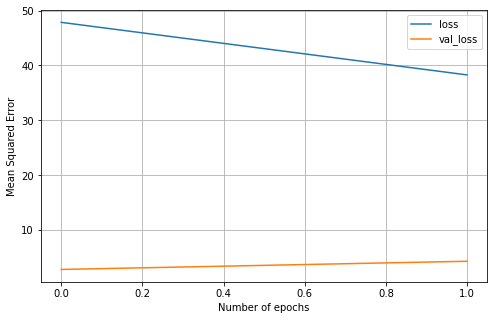

In [16]:
learning_rate=0.002

model = CustomModel(model_structure)

#Feed the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss_fn=tf.keras.losses.MeanSquaredError()
)

# Batch size is specified by the tf dataset
history = model.fit(train_ds_subset, epochs=50, verbose=2,
                    validation_data=(input_valid_subset, output_valid_subset)) ##
#     history = model.fit(train_ds, epochs=epochs, validation_data=valid_ds, callbacks=[time_callback])

# #Save the output
# train_loss = model.evaluate(input_train, output_train, verbose=2, batch_size=2000)
# valid_loss = model.evaluate(input_valid, output_valid, verbose=2, batch_size=1000)
# (train_loss, valid_loss)

# with open(os.path.join(path_model, filename+'.txt'), 'a') as file:
#         file.write('Results from the %d-th fold\n'%(i+1))
#         file.write('Training loss: %.4f\n'%(train_loss))
#         file.write('Validation loss: %.4f\n'%(valid_loss))
#         file.write('Training epochs: %d\n'%(len(history.history['val_loss'])))
#         file.write('Weights restored from epoch: %d\n\n'%(1+np.argmin(history.history['val_loss'])))
# model_bias.append(store_mean_model_biases(input_valid, output_valid))

# # Save bias plot
# save_figure(fig_name='cross_validation_results_%s'%days, model_biases=model_bias)

#Plotting the training progress
if len(history.history['loss']) > len(history.history['val_loss']):
    del history.history['loss'][-1]
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.ylabel('Mean Squared Error')
plt.xlabel('Number of epochs')
plt.savefig(os.path.join(path_figures, 
                         'test_learning_rate_%.4f.pdf'%(learning_rate)))
# plt.show()

In [ ]:
learning_rate=0.00005

model = CustomModel(model_structure)

#Feed the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss_fn=tf.keras.losses.MeanSquaredError()
)

# Batch size is specified by the tf dataset
history = model.fit(train_ds, epochs=30, verbose=2,
                    validation_data=(input_valid, output_valid))
#     history = model.fit(train_ds, epochs=epochs, validation_data=valid_ds, callbacks=[time_callback])

# #Save the output
# train_loss = model.evaluate(input_train, output_train, verbose=2, batch_size=2000)
# valid_loss = model.evaluate(input_valid, output_valid, verbose=2, batch_size=1000)
# (train_loss, valid_loss)

# with open(os.path.join(path_model, filename+'.txt'), 'a') as file:
#         file.write('Results from the %d-th fold\n'%(i+1))
#         file.write('Training loss: %.4f\n'%(train_loss))
#         file.write('Validation loss: %.4f\n'%(valid_loss))
#         file.write('Training epochs: %d\n'%(len(history.history['val_loss'])))
#         file.write('Weights restored from epoch: %d\n\n'%(1+np.argmin(history.history['val_loss'])))
# model_bias.append(store_mean_model_biases(input_valid, output_valid))

# # Save bias plot
# save_figure(fig_name='cross_validation_results_%s'%days, model_biases=model_bias)

#Plotting the training progress
if len(history.history['loss']) > len(history.history['val_loss']):
    del history.history['loss'][-1]
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.ylabel('Mean Squared Error')
plt.xlabel('Number of epochs')
# plt.savefig(os.path.join(path_figures, 
#                          'cross_validation_column_based_training_%s_fold_%d.pdf'%(days,i)))
plt.show()

In [ ]:
learning_rate=0.001

model = CustomModel(model_structure)

#Feed the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss_fn=tf.keras.losses.MeanSquaredError()
)

# Batch size is specified by the tf dataset
history = model.fit(train_ds, epochs=30, verbose=2,
                    validation_data=(input_valid, output_valid))
#     history = model.fit(train_ds, epochs=epochs, validation_data=valid_ds, callbacks=[time_callback])

# #Save the output
# train_loss = model.evaluate(input_train, output_train, verbose=2, batch_size=2000)
# valid_loss = model.evaluate(input_valid, output_valid, verbose=2, batch_size=1000)
# (train_loss, valid_loss)

# with open(os.path.join(path_model, filename+'.txt'), 'a') as file:
#         file.write('Results from the %d-th fold\n'%(i+1))
#         file.write('Training loss: %.4f\n'%(train_loss))
#         file.write('Validation loss: %.4f\n'%(valid_loss))
#         file.write('Training epochs: %d\n'%(len(history.history['val_loss'])))
#         file.write('Weights restored from epoch: %d\n\n'%(1+np.argmin(history.history['val_loss'])))
# model_bias.append(store_mean_model_biases(input_valid, output_valid))

# # Save bias plot
# save_figure(fig_name='cross_validation_results_%s'%days, model_biases=model_bias)

#Plotting the training progress
if len(history.history['loss']) > len(history.history['val_loss']):
    del history.history['loss'][-1]
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.ylabel('Mean Squared Error')
plt.xlabel('Number of epochs')
# plt.savefig(os.path.join(path_figures, 
#                          'cross_validation_column_based_training_%s_fold_%d.pdf'%(days,i)))
plt.show()